# Ear Tracking tutorial

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import openalea.eartrack.eartrack as et_lib
import openalea.eartrack.binarisation_folder as st_lib


## Get example images and parameters needed for segmentation and ear tracking

In [2]:
output_folder = os.path.join(os.path.expanduser('~'), 'ear_tracking_results')
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# Read images' information and create output folders
# TODO read images from zenodo

images_folder = os.path.join('..', 'share','data')

img_desc, parameters = st_lib.init(images_folder, output_folder)


## Selection of one plant and one imaging task

In [3]:
plant = img_desc.keys()[0]
task = img_desc[plant].keys()[0]

results_folder = os.path.join(output_folder, str(plant), 'results')
cabin = img_desc[plant][task]['cabin']
task_folder = os.path.join(output_folder, str(plant), str(task))

## Read images and show them

<IPython.core.display.Javascript object>


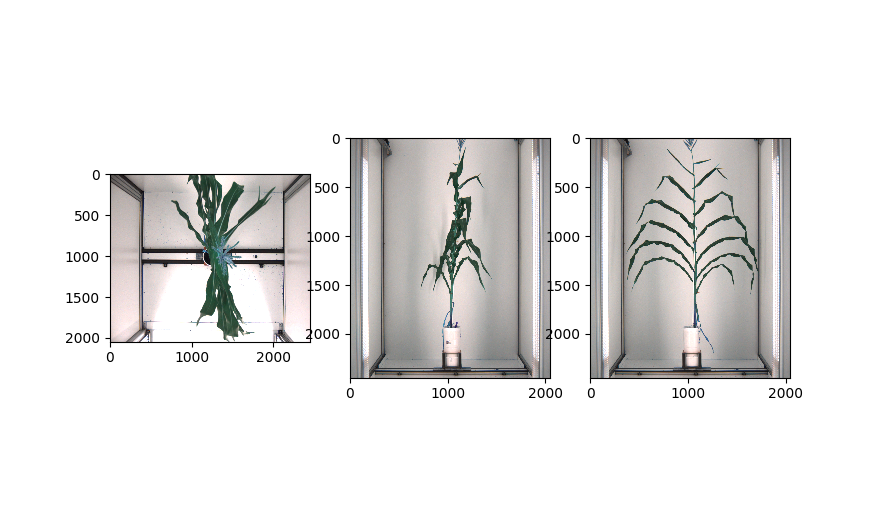

In [4]:
%matplotlib notebook
images = st_lib.read_images(img_desc, plant, task)
fig, axes = plt.subplots(nrows=1, ncols=3)
axlist = fig.get_axes()
axlist[0].imshow(images["top"][0])
axlist[1].imshow(images["side"][0])
axlist[2].imshow(images["side"][90])


## Compute binaries and show them

<IPython.core.display.Javascript object>


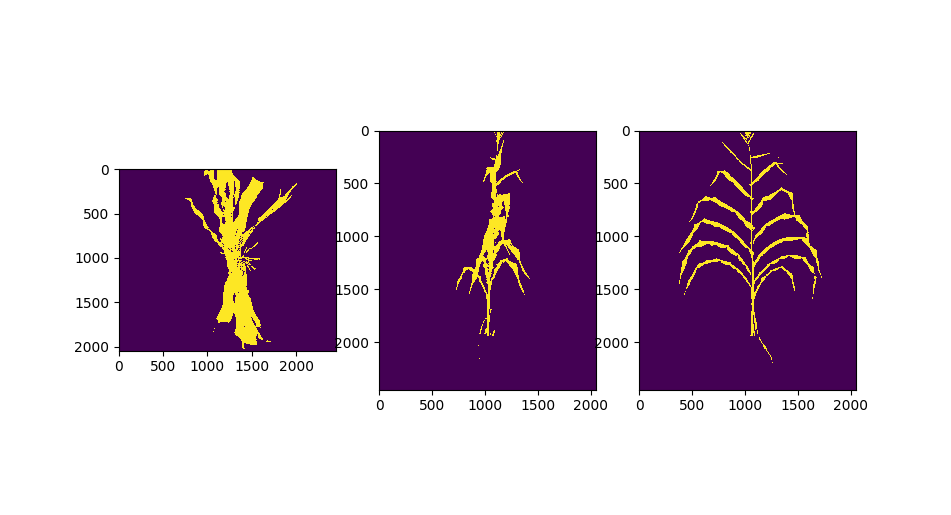

In [5]:
binaries, mask_top_center = st_lib.binaries_calculation(images, cabin, parameters)

fig, axes = plt.subplots(nrows=1, ncols=3)
axlist = fig.get_axes()
axlist[0].imshow(binaries["top"][0])
axlist[1].imshow(binaries["side"][0])
axlist[2].imshow(binaries["side"][90])


<IPython.core.display.Javascript object>


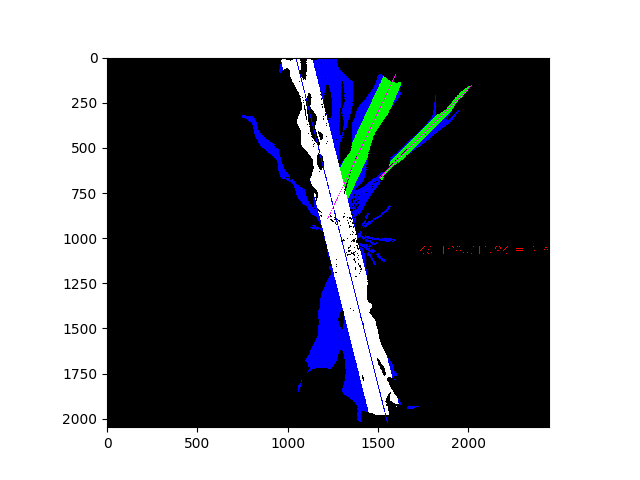

In [6]:
existing_angles = binaries["side"].keys()
angles_to_keep, result_img, top_log = et_lib.top_analyse(binaries["top"][0], existing_angles, mask_top_center)
fig = plt.figure()
plt.imshow(result_img)



In [7]:
kept_positions = np.empty([0, 3], 'int')
useful_kept_images = np.empty([0], 'int')
for angle in angles_to_keep:
    positions, imagesUtiles, debug = et_lib.side_analyse(binaries["side"][angle],
                                                         images["side"][angle],
                                                         angle,
                                                         task_folder,
                                                         parameters[cabin]["side"]["pot_height"],
                                                         parameters[cabin]["side"]["pot_width"],)
    kept_positions = np.append(kept_positions, positions, axis=0)
    useful_kept_images = np.append(useful_kept_images, imagesUtiles, axis=0)

In [8]:
values = np.empty([0, 2], 'int')
im = np.empty([0], 'int')
for i in range(len(kept_positions)):
    for j in range(kept_positions[i, 2]):
        values = np.append(values, [kept_positions[i, 0:2]], axis=0)
        im = np.append(im, useful_kept_images[i])
mean_pos, finales_positions, final_kept_images = et_lib.robust_mean(values, im)
finales_positions = np.append(finales_positions, np.array([final_kept_images]).T, 1)

<IPython.core.display.Javascript object>


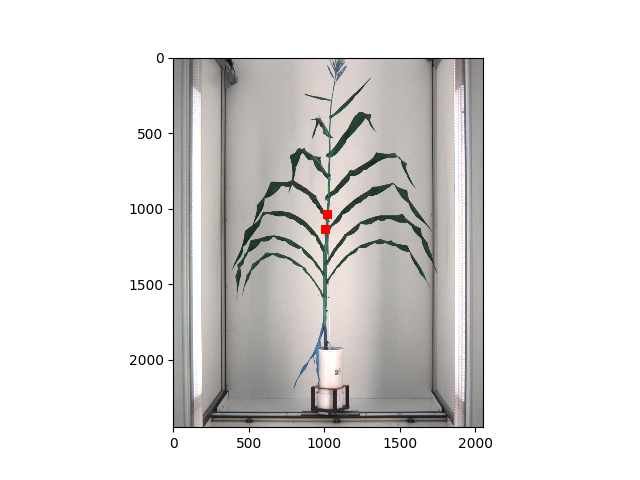

In [9]:
imageFinale = images["side"][finales_positions[0, 2]].copy()
if not (mean_pos == [-1, -1]).all():
    imageFinale[mean_pos[0] - 20:mean_pos[0] + 21, mean_pos[1]-20:mean_pos[1] + 21, :] = (255, 0, 0)
elif finales_positions.shape[0] == 2:
    for pos in finales_positions:
        imageFinale[pos[0] - 30:pos[0] + 31, pos[1] - 30:pos[1] + 31, :] = (255, 0, 0)
fig = plt.figure()
plt.imshow(imageFinale)
